# Cargar Imágenes

In [1]:
import requests
import zipfile
import io
import warnings
import os
import shutil
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import set_random_seed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  

def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)

2025-09-02 07:44:46.054788: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-02 07:44:46.322660: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-02 07:45:03.123001: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-02 07:45:12.603354: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [ ]:
url = "https://storage.googleapis.com/datascience-materials/dogs-vs-cats.zip"
response = requests.get(url)
response.raise_for_status()

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall("../data")

In [2]:
images_folder = "../data/dogs-vs-cats/train"
train_folder = "../data/train"
cats_folder = "../data/all/cats"
dogs_folder = "../data/all/dogs"

In [ ]:
os.makedirs(train_folder, exist_ok=True)
os.makedirs(cats_folder, exist_ok=True)
os.makedirs(dogs_folder, exist_ok=True)

for filename in os.listdir(images_folder):
    file_path = os.path.join(images_folder, filename)
    if os.path.isfile(file_path):
        if filename.lower().startswith("cat"):
            shutil.move(file_path, os.path.join(cats_folder, filename))
        elif filename.lower().startswith("dog"):
            shutil.move(file_path, os.path.join(dogs_folder, filename))

## Dividimos las imágenes en grupos de entrenamiento y pruebas

In [3]:
source_dir = "../data/all"
train_dir = "../data/train"
test_dir = "../data/test"

In [4]:
cats_folder = os.path.join(source_dir, "cats")
dogs_folder = os.path.join(source_dir, "dogs")

cats = len(os.listdir(cats_folder))
dogs = len(os.listdir(dogs_folder))

# sample 1% of each class
p_cats = int(cats * 0.05)
p_dogs = int(dogs * 0.05)

# split 80/20 train/test
n_cats_train = int(p_cats * 0.8)
n_cats_test = p_cats - n_cats_train

n_dogs_train = int(p_dogs * 0.8)
n_dogs_test = p_dogs - n_dogs_train

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ["cats", "dogs"]

for cls in classes:
    cls_path = os.path.join(source_dir, cls)
    files = os.listdir(cls_path)
    random.shuffle(files)  # shuffle to avoid bias

    if cls == "cats":
        selected_files = files[:p_cats]
        train_files = selected_files[:n_cats_train]
        test_files = selected_files[n_cats_train:]
    else:
        selected_files = files[:p_dogs]
        train_files = selected_files[:n_dogs_train]
        test_files = selected_files[n_dogs_train:]

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

    for f in train_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(train_dir, cls, f))
    for f in test_files:
        shutil.copy(os.path.join(cls_path, f), os.path.join(test_dir, cls, f))

    print(f"{cls}: {len(train_files)} train, {len(test_files)} test")

cats: 500 train, 125 test
dogs: 500 train, 125 test


## Reescalamos las imágenes

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(224, 224),
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    batch_size=32
                                                    )

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  target_size=(224, 224),
                                                  class_mode='binary',
                                                  shuffle=False,
                                                  batch_size=32
                                                  )

Found 1000 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


Configurando shuffle = True en train_generator, garantizamos que las imágenes de entrenamiento se mezclen en cada epoch, evitando que el modelo aprenda patrones del orden. Por otro lado, al configurar shuffle = False en test_generator mantenemos siempre el mismo orden para poder comparar con y_true al evaluar.

# Construir un ANN

## Inicializamos el Modelo

Usaremos una configuración sencilla para poder entrenar el modelo

In [8]:
set_random_seed(42)

model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation="relu"),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

## Definimos las épocas del entrenamiento y el tamaño de los lotes

In [9]:
epochs = 150  
batch_size = 32  

## Entrenamos el Modelo

In [10]:
model_history = model.fit(  
    train_generator,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = train_generator.samples // batch_size)

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 899ms/step - accuracy: 0.5290 - loss: 0.8461 - val_accuracy: 0.5000 - val_loss: 0.6888
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 876ms/step - accuracy: 0.5930 - loss: 0.6728 - val_accuracy: 0.5720 - val_loss: 0.6650
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 908ms/step - accuracy: 0.5930 - loss: 0.6561 - val_accuracy: 0.6280 - val_loss: 0.6699
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 917ms/step - accuracy: 0.6210 - loss: 0.6444 - val_accuracy: 0.6200 - val_loss: 0.6401
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 902ms/step - accuracy: 0.6120 - loss: 0.6453 - val_accuracy: 0.6640 - val_loss: 0.6535
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 906ms/step - accuracy: 0.6320 - loss: 0.6401 - val_accuracy: 0.6280 - val_loss: 0.6366
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 906ms/step - accuracy: 0.6580 - loss: 0.6275 - val_accuracy: 0.7200 - val_loss: 0.5683
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 869ms/step - accuracy: 0.6820 - loss: 0.6131 - 

Después de entrenar el modelo con 150 épocas, podemos ver que está aprendiendo bastante bien sobre los datos de entrenamiento, aunque no alcanza una precisión alta. La precisión en los datos de validación es significativamente menor que en entrenamiento, lo que indica que el modelo no generaliza tan bien en datos nuevos. La pérdida en validación es mucho mayor que en entrenamiento.

In [11]:
loss, accuracy = model.evaluate(train_generator)
print(f"Train Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 393ms/step - accuracy: 0.9510 - loss: 0.1353
Train Accuracy: 0.9510


In [12]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.8040 - loss: 1.0656
Test Accuracy: 0.8040


## Matriz de Confusión

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step


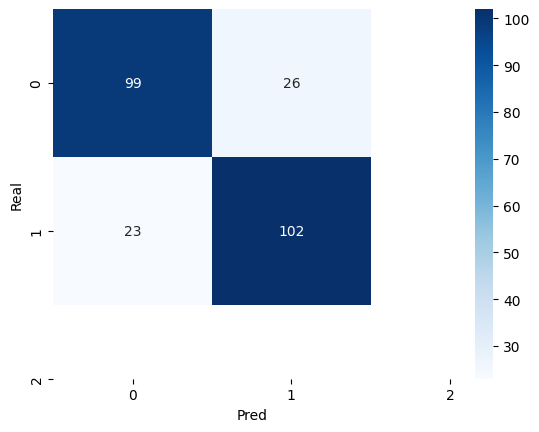

In [13]:
y_true = test_generator.classes
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = (y_pred > 0.5).astype("int32").ravel()

from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(y_true, y_pred_classes)
cm = confusion_matrix(y_true, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2],
            yticklabels=[0,1,2])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()


En la matriz de confusión vemos, de forma más clara, que el modelo no es capaz de generalizar todas las instancias y que sobre el 20% de los valores son FP y FN.

Vemos que el modelo no generaliza correctamente, clasificando como perros instancias que son gatos. Esto sugiere que el modelo podría estar aprendiendo mal por sobreajuste.

## Graficamos los resultados del entrenamiento

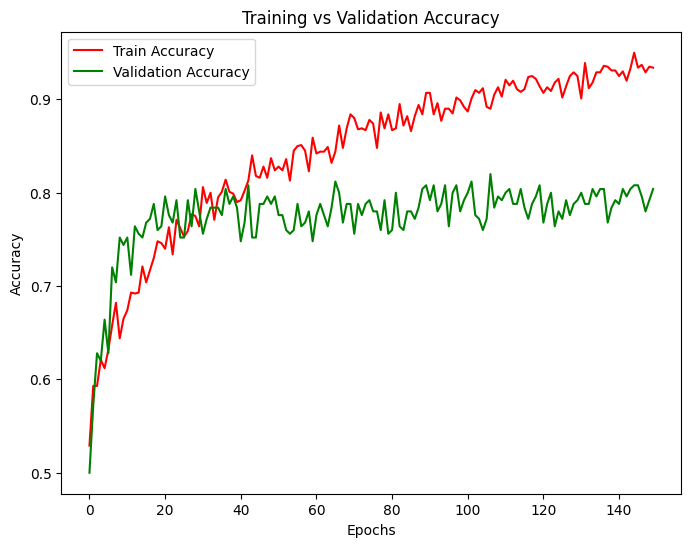

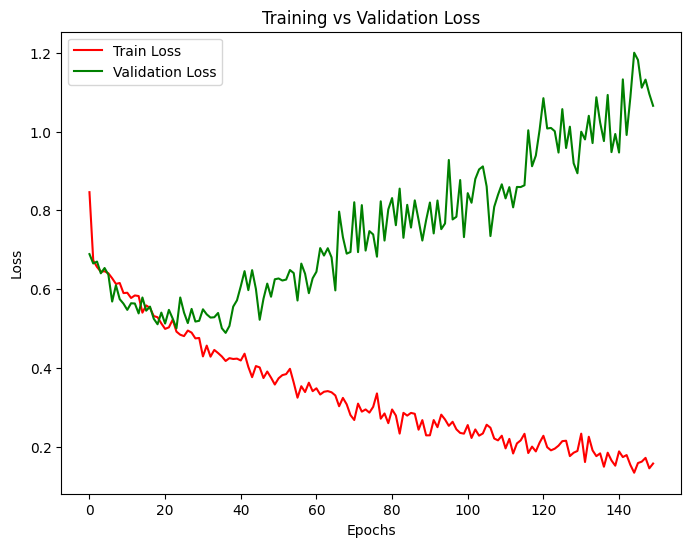

In [14]:
plt.figure(figsize=(8,6))
plt.plot(model_history.history['accuracy'], 'r', label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], 'g', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(8,6))
plt.plot(model_history.history['loss'], 'r', label='Train Loss')
plt.plot(model_history.history['val_loss'], 'g', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

Podemos ver en el gráfico ***Training vs Validation Accuracy*** que el *training accuracy* aumenta, lo que significa que el modelo cada vez memoriza mejor los ejemplos de entrenamiento. Sin embargo, el *validation accuracy* se mantiene constante, lo que significa que el modelo no generaliza bien a datos nuevos y empieza a fallar fuera del conjunto de entrenamiento.

También vemos que el gráfico de ***Training vs Validation Loss*** sugiere que sobre la época 20 hay sobreajuste, pues vemos que el *training loss* sigue decreciendo mientras que el *validation loss* comienza a aumentar.

## Guardamos el Modelo

In [15]:
pickle.dump(model, open("../models/ANN_default.sav", "wb"))

# Optimizar el Modelo

## ModelCheckpoint y EarlyStopping

Al modelo previamente definido agregaremos nuevos parámetros:

- *Checkpoint*, que guarda el mejor modelo en un archivo
- *EarlyStopping*, que detiene el entrenamiento si el modelo deja de mejorar en validación.
- *ReduceLROnPlateau*, que baja el learning rate automáticamente cuando el modelo deja de mejorar.

In [16]:
set_random_seed(42)

model_opt = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    MaxPool2D((2,2)),
    Conv2D(64, (3,3), activation="relu"),
    MaxPool2D((2,2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

model_opt.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

checkpoint = ModelCheckpoint("best_model.h5", 
                             monitor="val_loss", 
                             save_best_only=True, 
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss', 
                           patience=8, 
                           verbose=1, 
                           min_delta=1e-4, 
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=4, 
                              verbose=1, 
                              min_delta=1e-4)

callbacks_list = [checkpoint, early_stop, reduce_lr]

In [17]:
model_history_opt = model_opt.fit(  
    train_generator,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = train_generator.samples // batch_size,
    callbacks = callbacks_list)

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.4925 - loss: 0.9769
Epoch 1: val_loss improved from None to 0.67915, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 917ms/step - accuracy: 0.5090 - loss: 0.8001 - val_accuracy: 0.5720 - val_loss: 0.6792 - learning_rate: 0.0010
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 882ms/step - accuracy: 0.5758 - loss: 0.6663
Epoch 2: val_loss improved from 0.67915 to 0.67891, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 947ms/step - accuracy: 0.5760 - loss: 0.6685 - val_accuracy: 0.5960 - val_loss: 0.6789 - learning_rate: 0.0010
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.6147 - loss: 0.6627
Epoch 3: val_loss improved from 0.67891 to 0.67003, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 955ms/step - accuracy: 0.6070 - loss: 0.6606 - val_accuracy: 0.5760 - val_loss: 0.6700 - learning_rate: 0.0010
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.5823 - loss: 0.6511
Epoch 4: val_loss improved from 0.67003 to 0.65565, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 935ms/step - accuracy: 0.5880 - loss: 0.6492 - val_accuracy: 0.6160 - val_loss: 0.6556 - learning_rate: 0.0010
Epoch 5/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.6067 - loss: 0.6484
Epoch 5: val_loss did not improve from 0.65565
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 951ms/step - accuracy: 0.6160 - loss: 0.6433 - val_accuracy: 0.5880 - val_loss: 0.6676 - learning_rate: 0.0010
Epoch 6/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.6151 - loss: 0.6428
Epoch 6: val_loss improved from 0.65565 to 0.65068, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 884ms/step - accuracy: 0.6320 - loss: 0.6418 - val_accuracy: 0.6080 - val_loss: 0.6507 - learning_rate: 0.0010
Epoch 7/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.6425 - loss: 0.6075
Epoch 7: val_loss improved from 0.65068 to 0.62445, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 885ms/step - accuracy: 0.6350 - loss: 0.6254 - val_accuracy: 0.6960 - val_loss: 0.6245 - learning_rate: 0.0010
Epoch 8/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 829ms/step - accuracy: 0.6451 - loss: 0.6202
Epoch 8: val_loss did not improve from 0.62445
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 912ms/step - accuracy: 0.6620 - loss: 0.6118 - val_accuracy: 0.6240 - val_loss: 0.6590 - learning_rate: 0.0010
Epoch 9/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.6682 - loss: 0.6169
Epoch 9: val_loss improved from 0.62445 to 0.61916, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 911ms/step - accuracy: 0.6600 - loss: 0.6241 - val_accuracy: 0.6800 - val_loss: 0.6192 - learning_rate: 0.0010
Epoch 10/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.7016 - loss: 0.5796
Epoch 10: val_loss improved from 0.61916 to 0.59664, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 888ms/step - accuracy: 0.6790 - loss: 0.6006 - val_accuracy: 0.7200 - val_loss: 0.5966 - learning_rate: 0.0010
Epoch 11/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.6848 - loss: 0.5837
Epoch 11: val_loss improved from 0.59664 to 0.59047, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 30s 897ms/step - accuracy: 0.6690 - loss: 0.6045 - val_accuracy: 0.7240 - val_loss: 0.5905 - learning_rate: 0.0010
Epoch 12/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 855ms/step - accuracy: 0.6995 - loss: 0.5801
Epoch 12: val_loss did not improve from 0.59047
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 901ms/step - accuracy: 0.6860 - loss: 0.5892 - val_accuracy: 0.7080 - val_loss: 0.6228 - learning_rate: 0.0010
Epoch 13/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.7087 - loss: 0.5772
Epoch 13: val_loss did not improve from 0.59047
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 872ms/step - accuracy: 0.6950 - loss: 0.5838 - val_accuracy: 0.6960 - val_loss: 0.6354 - learning_rate: 0.0010
Epoch 14/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.6733 - loss: 0.5876
Epoch 14: val_loss did not improve from 0.59047
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 889ms/step - accuracy: 0.6830 - loss: 0.5928 - val_accuracy: 0.7000 - val_loss: 0.5913 - learning_rate: 0.0010
Epoch 15/150
32/32 ━━━━━

32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 884ms/step - accuracy: 0.7060 - loss: 0.5572 - val_accuracy: 0.7480 - val_loss: 0.5759 - learning_rate: 1.0000e-04
Epoch 17/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.7250 - loss: 0.5291
Epoch 17: val_loss improved from 0.57591 to 0.57489, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 901ms/step - accuracy: 0.7350 - loss: 0.5304 - val_accuracy: 0.7360 - val_loss: 0.5749 - learning_rate: 1.0000e-04
Epoch 18/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.7411 - loss: 0.5252
Epoch 18: val_loss improved from 0.57489 to 0.57164, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 41s 913ms/step - accuracy: 0.7430 - loss: 0.5173 - val_accuracy: 0.7320 - val_loss: 0.5716 - learning_rate: 1.0000e-04
Epoch 19/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.7449 - loss: 0.5201
Epoch 19: val_loss improved from 0.57164 to 0.56721, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 904ms/step - accuracy: 0.7470 - loss: 0.5204 - val_accuracy: 0.7480 - val_loss: 0.5672 - learning_rate: 1.0000e-04
Epoch 20/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.7447 - loss: 0.5054
Epoch 20: val_loss improved from 0.56721 to 0.56491, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 937ms/step - accuracy: 0.7340 - loss: 0.5082 - val_accuracy: 0.7360 - val_loss: 0.5649 - learning_rate: 1.0000e-04
Epoch 21/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 850ms/step - accuracy: 0.7474 - loss: 0.5041
Epoch 21: val_loss did not improve from 0.56491
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 899ms/step - accuracy: 0.7560 - loss: 0.5032 - val_accuracy: 0.7320 - val_loss: 0.5773 - learning_rate: 1.0000e-04
Epoch 22/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.7269 - loss: 0.5250
Epoch 22: val_loss did not improve from 0.56491
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 888ms/step - accuracy: 0.7420 - loss: 0.5194 - val_accuracy: 0.7360 - val_loss: 0.5828 - learning_rate: 1.0000e-04
Epoch 23/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.7451 - loss: 0.5134
Epoch 23: val_loss did not improve from 0.56491
32/32 ━━━━━━━━━━━━━━━━━━━━ 40s 876ms/step - accuracy: 0.7410 - loss: 0.5143 - val_accuracy: 0.7360 - val_loss: 0.5708 - learning_rate: 1.0000e-04
Epoch 24

Con un *accuracy* del 78%, el modelo aprendió muy bien el set de entrenamiento, pero el *validation accuracy* se quedó en 78%, lo que indica que no hubo. El *early stopping* evitó que el modelo se siga memorizando y lo dejó en el punto más balanceado, que es la época 20.

In [18]:
loss, accuracy = model_opt.evaluate(train_generator)
print(f"Train Accuracy: {accuracy:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step - accuracy: 0.7420 - loss: 0.5127
Train Accuracy: 0.7420


In [19]:
loss, accuracy = model_opt.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.7360 - loss: 0.5649
Test Accuracy: 0.7360


## Matriz de Confusión

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 196ms/step


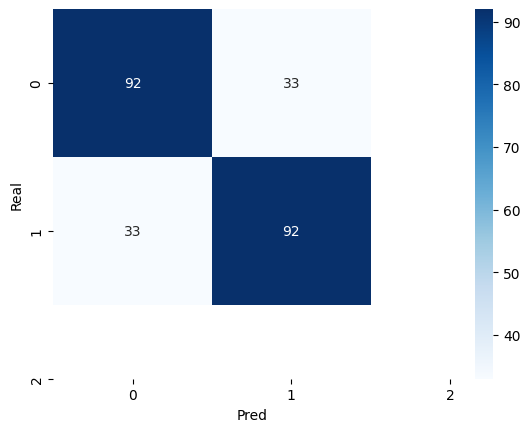

In [20]:
y_true = test_generator.classes
y_pred = model_opt.predict(test_generator, verbose=1)
y_pred_classes = (y_pred > 0.5).astype("int32").ravel()

from sklearn.metrics import accuracy_score, confusion_matrix

acc = accuracy_score(y_true, y_pred_classes)
cm = confusion_matrix(y_true, y_pred_classes)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1,2],
            yticklabels=[0,1,2])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.show()

En la matriz de confusión vemos, de forma más clara, que el modelo no es capaz de generalizar todas las instancias y que sobre el 26% de los valores son FP y FN.

## Graficamos los resultados del entrenamiento

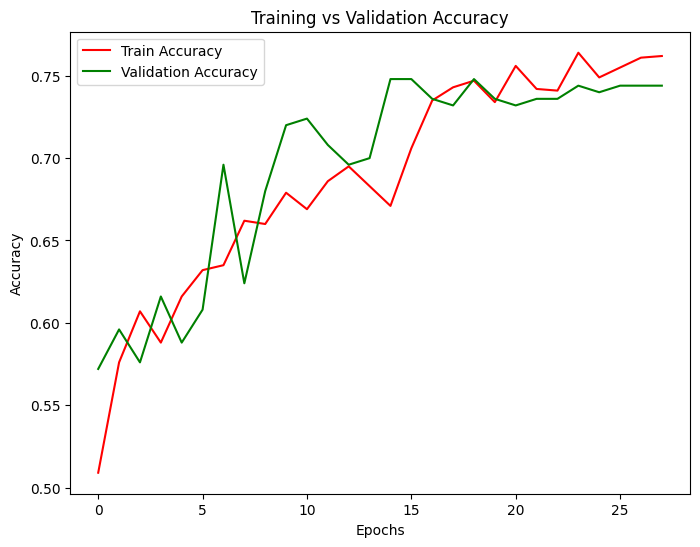

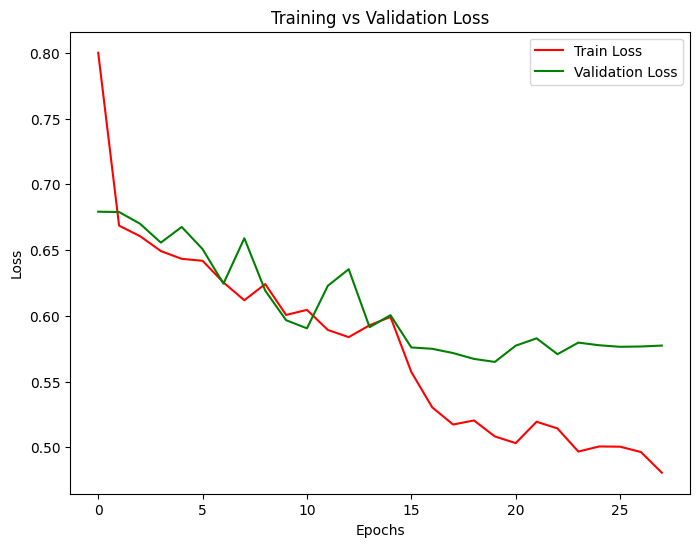

In [21]:
plt.figure(figsize=(8,6))
plt.plot(model_history_opt.history['accuracy'], 'r', label='Train Accuracy')
plt.plot(model_history_opt.history['val_accuracy'], 'g', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(8,6))
plt.plot(model_history_opt.history['loss'], 'r', label='Train Loss')
plt.plot(model_history_opt.history['val_loss'], 'g', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

Podemos ver en el gráfico ***Training vs Validation Accuracy*** que tanto el *train accuracy* como el *validation accuracy* aumentan, lo que sugiere que el modelo cada vez memoriza mejor los ejemplos de entrenamiento y generaliza razonablemente bien.

También vemos que el gráfico de ***Training vs Validation Loss*** que sobre la época 25 el *training loss* se mantiene constante mientras que el *validation loss* comienza a decrecer. Por esto el modelo hace un early stopping y se considera la época 25 como el punto óptimo de entrenamiento.

## Guardamos el Modelo

In [22]:
pickle.dump(model_opt, open("../models/ANN_opt.sav", "wb"))